---
title: "Tackling Tabular Problems II: Model Validation & Evaluation"
date: "2022-11-03"
format:
  html:
    code-fold: true
    code-line-numbers: false
jupyter: python3
---

## Model Validation

A proper validation strategy is key for building a good model. Without a good validation scheme, we won't be able to correctly evaluate a model's prediction errors; hence, we won't know which changes really lead to a performance improvement. Thus, investing time in designing a reliable validation scheme is crucial for the success of a project.

In essence, the question of model evaluation boils down to deciding how the dataset is partitioned in samples for training and samples for validation and testing. The most basic strategy is a simple train-test split that splits the dataset into a training set (e.g., 80% of the data) and a test set. But since this strategy involves regularly checking the model's performance on the test set, it will quickly lead to overfitting. Thus, we can improve this strategy by splitting the data into three parts (i.e., separate sets for training, validation, and testing) and use the test set only for estimating the final performance of the model on unseen data. The best practice, however, is to first put aside the test set and then use a flavor of k-fold cross-validation (CV) to evaluate the training procedure on the remaining data. This way, we further reduce the risk of overfitting and can get a more reliable estimate of the model's performance. For a more thorough discussion of this topic, see this popular [paper](https://arxiv.org/pdf/1811.12808.pdf). 

### CV Schemes

Let's dive deeper into the different variations of k-fold CV. 

Note: We borrow some code from the scikit-learn [user guide](https://scikit-learn.org/stable/modules/cross_validation.html) to visualize the different strategies.

In [ ]:
#| code-fold: true
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold

In [67]:
#| code-fold: true

def get_ax(figsize=(11, 4), grid=False, title=None, xlabel=None, ylabel=None):
    _, ax = plt.subplots(figsize=figsize)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_linewidth(1.1)
    if title is not None:
        ax.set_title(title, fontsize=12)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=10)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=10)

    return ax

# From https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
rng = np.random.RandomState(1)
cmap_data = plt.cm.jet
cmap_cv = plt.cm.gist_earth

# Generate the class/group data
n_points = 100
X = rng.randn(100, 10)

percentiles_classes = [0.1, 0.3, 0.6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

# Generate uneven groups
group_prior = rng.dirichlet([2] * 10)
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))

def plot_cv(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data)
    ax.scatter(range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title(str(type(cv).__name__), fontsize=12)
    return ax

#### k-fold CV

The most used version of $k$-fold CV is implemented in scikit-learn's `KFold` cross-validator.`KFold` simply splits the dataset into $k$ partitions (where $k$ is typically between $3$ and $10$). Then, in $k$ iterations, one of the $k$ partitions (or "folds") is used as a validation set while the others are used as a training set for the model (i.e., the model is trained on $k-1$ folds in every iteration). Eventually, we'll end up with predictions for every observation in the dataset (the so-called out-of-fold predictions, or oof in short, because in each iteration the model only predicts samples it has not seen during training). To obtain the overall CV score, we simply average the $k$ validation scores.

The plot below shows the basic k-fold CV scheme with $4$ folds. Note that the class and group structure of the data is ignored.

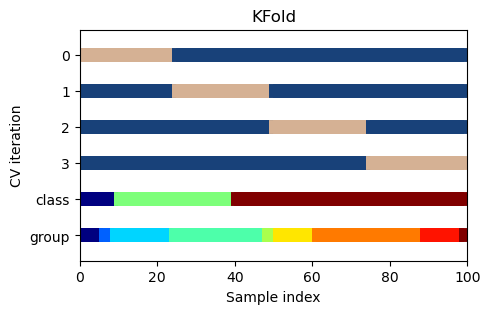

In [68]:
#| code-fold: true

_, ax = plt.subplots(figsize=(5, 3))
n_splits = 4
cv = KFold(n_splits)
plot_cv(cv, X, y, groups, ax, n_splits);

#### Stratified k-fold CV

In practice, it is often the case that there are some classes in the data (in the target and/or in features) that appear (much) less frequently than others. A typical example for an imbalanced target is transaction data where we have to predict the very rare event of a fraudulent transaction. In situations like this we'll want to preserve the class distribution in our validation scheme using *stratified* k-fold CV.

The plot below shows this strategy using scikit-learn's `StratifiedKFold` (stratified on the imbalanced target `y` which has three classes). 

Note that the same approach can be used in regression problems with skewed variables or variables that have long tails. To preserve the variable's distribution across folds we can simply stratify on a discretized version of that variable. If we need to preserve the distribution of multiple variables, we can use iterative stratification (an implementation can be found [here](http://scikit.ml/api/skmultilearn.model_selection.iterative_stratification.html#module-skmultilearn.model_selection.iterative_stratification)).

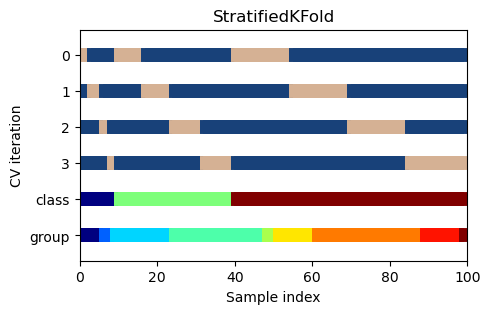

In [69]:
#| code-fold: true

_, ax = plt.subplots(figsize=(5, 3))
n_splits = 4
cv = StratifiedKFold(n_splits)
plot_cv(cv, X, y, groups, ax, n_splits);

#### Group k-fold CV

Another common issue concerns non-i.i.d. data. As an example, consider a dataset with data about many different users and multiple observations per user. If there are observations of a user in both the training and the validation data, we'll overestimate the model's performance on unseen users. Thus, we'll want to make sure that groups in the data appear either in the training or in the validation samples, but not in both. This functionality is implemented in scikit-learn's `GroupKFold`. Note that such groups in the data may only be revealed by thorough analysis (e.g., using cluster analysis) and leveraging domain knowledge. 

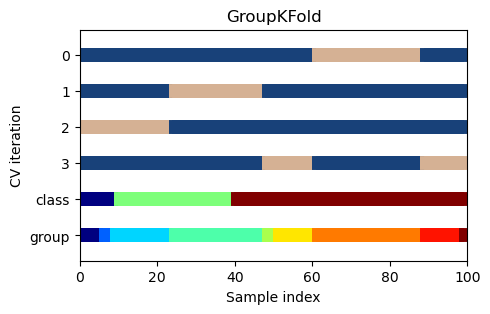

In [70]:

#| code-fold: true

_, ax = plt.subplots(figsize=(5, 3))
n_splits = 4
cv = GroupKFold(n_splits)
plot_cv(cv, X, y, groups, ax, n_splits);

#### Stratified group k-fold CV

Naturally, we may face a problem where want to preserve the distribution of a variable *and* split on groups. This can be done using scikit-learn's `StratifiedGroupKFold`. Note: If the distribution of classes in each group is relatively close it is better to use `GroupKFold`.

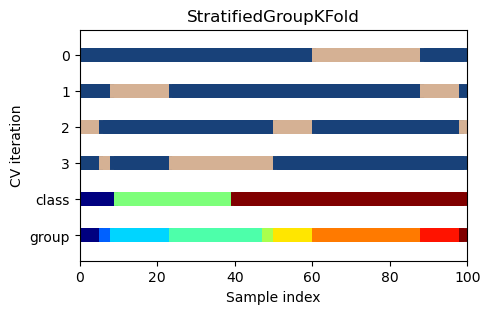

In [71]:
#| code-fold: true

_, ax = plt.subplots(figsize=(5, 3))
n_splits = 4
cv = StratifiedGroupKFold(n_splits)
plot_cv(cv, X, y, groups, ax, n_splits);

#### Shuffling

In the examples above, the data wasn't shuffled before the partitioning of the data. But if the ordering of the data is not arbitrary (e.g., if the observations are ordered by class), shuffling is usually necessary (just set `shuffle=True` when instantiating the cross-validator). However, care must be taken if there is a time dimension in the data (e.g., multiple observations of a physical process that are close in time). In this case, shuffling the data may put samples in the validation set that are very similar to the ones in the training set.

#### Nested CV

We generally shouldn't use the same data for optimizing the hyperparameters of a model and evaluating its performance. This is where nested CV comes in. The idea is simple: We'll still use an outer loop that splits the dataset into $k$ folds at each iteration. But we'll also use an inner loop that splits the data again to get a new set of samples for training and validation in each (inner) iteration. Since the hyperparameter tuning only happens with respect to the data exposed by the outer loop, the risk of overfitting is reduced. However, this comes at the price of much higher computational effort and a reduced amount of available training data. Thus, we'll often resort to using the same CV scheme for both model/parameter search and model evaluation even though this poses a higher risk of overfitting.

### Adverserial validation

While adverserial validation is not a classic validation strategy, it can be really helpful to determine the reliability of an existing validation scheme. For example, we may be unsure whether we really picked a representative sample of our dataset for testing our model. To answer this question, we can follow a simple procedure: Concatenate the training and the test data, delete the target column, add a binary column indicating whether a row comes from the training or the test set, and train a classifier (e.g., a Random Forest) to predict this new target. Ideally, the resulting classifier will have a ROC-AUC around $0.5$ meaning that it cannot tell both datasets apart. A ROC-AUC closer to $1.0$ would instead indicate that the training and the test data come from different distributions and that our validation method isn't robust. Note that we can use the same approach to detect concept drift (i.e., changing patterns and relations over time) in our data. 

### Avoiding data leaks

No matter which specific validation strategy is chosen, it is imperative to avoid information leaks from the training data to the validation/test data. There are multiple potential sources for these leaks, common ones are:
- Preprocessing: Preprocessing methods (e.g., normalization, target encoding, dimensionality reduction) have to be fitted exclusively on the training set. If a preprocessing method modifies the entire data (i.e., before it is partitioned into training, validation, and test data), information inevitably leaks from the training data.
- Availability of features: The dataset may contain features that are not available at inference time. This probably sounds obvious but can be complicated in practice (e.g., sensor data may be collected before a prediction has to be made but won't become available in time), and has to be fixed (either by dropping the feature or making sure that it is available).
- Groups: This was already discussed, but finding these groups can be very hard. Imagine a dataset containing some kind of rating created by human evaluators. If the rows are sorted by evaluator (and the ratings aren't perfectly objective), there is a leak in the ordering of the observations.

## Metrics

Choosing the right metric(s) is important in any ML task. While we may first think of the typical (mathematical) metrics for evaluating the predictive performance of a model (i.e., metrics that compare the predictions and the ground truth to compute a score), there are usually a lot of other relevant metrics in a project. Some examples are:
- interpretability of the model
- maintainability of the model
- memory and compute requirements
- training and inference costs
- latency of the inference process
- time for development

Which criteria matter the most heavily depends on the project. 

Here, we'll take a brief look at the most common (mathematical) evaluation metrics for regression and classification. But first, some general remarks about evaluation metrics:
- The metric should be chosen according to the requirements of the project. For instance, if it is more important to avoid underestimation than overestimation, the metric should reflect this. Also, it is always possible to check multiple metrics.
- In an ideal setting, the evaluation metric matches the objective function used by the model. Note that GBDTs and deep learning models generally allow custom objective functions.
- If the evaluation metric doesn't match the objective function, it is essential to at least tune the hyperparameters of the model based on the metric we really care about.

### Metrics for regression

#### Mean squared error (MSE)

The MSE is the mean of the sum of squared errors (SSE). To compute the SSE we simply sum the squared differences between the predictions and the ground truth. Since regression models typically minimize the SSE, it is usually straightforward to minimize the MSE. Expressed mathematically:

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \frac{1}{n}\text{SSE},$$

where $y_i$ represents the ground truth, and $\hat{y}_i$ the prediction.

#### Root mean squared error (RMSE)

RMSE is the square root of the MSE, and often used in regression problems. It is generally preferred for two reasons:
- its value is on the original scale of the target (since we take the *root* of *squared* errors), allowing a more intuitive understanding
- it penalizes large prediction errors to a lesser extent than MSE (again, due to taking the square root)

Expressed mathematically:

$$\text{RMSE} = \sqrt{\text{MSE}} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}.$$

In practice, it may work better to take the square root of the target and use MSE as objective function (squaring the results afterwards). 

#### R squared ($R^2$)

The $R^2$ metric compares the squared errors of the model against the squared errors when predicting the mean of the target (which is also known as the sum of squares total, SST). Expressed mathematically:

$$R^2 = \sum_{i=1}^{n} \frac{(y_i - \hat{y}_i)^2}{(y_i - \bar{y})^2} = \frac{\text{SSE}}{\text{SST}},$$

where $\bar{y}$ represents the mean of the target.

#### Root mean squared log error (RMSLE)

RMSLE is another extension of the MSE and a good choice when we care about the scale of our predictions with respect to the scale of the ground truth (due to taking the logarithm, we focus on the relative error between the predicted and the actual values). Note that RMSLE penalizes underestimation more than overestimation. Expressed mathematically:

$$\text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \log(\hat{y}_i + 1) - \log(y_i + 1) \right)^2},$$

where $\log(x)$ means the natural logarithm of $x$.

In practice, it may work better to take the logarithm of the target before fitting the model (putting the results back on the original scale using the exponential function afterwards).

#### Mean absolute error (MAE)

The MAE represents the mean of the absolute differences between the predictions and the ground truth. It is on the original scale of the target and less sensitive to outliers (given that there is no squaring operation). Expressed mathematically:

$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \lvert y_i - \hat{y}_i \rvert$$

### Metrics for binary classification

#### Accuracy

Accuracy, the number of correct predictions as a ratio of all predictions, is the simplest metric for binary classification problems. However, it is only easily interpretable when there is no class imbalance. For instance, if the minority class makes up only 5% of the data, a model that only predicts the majority class will have an accuracy of 95%. Expressed mathematically:

$$\text{Accuracy} = \frac{\text{correct predictions}}{\text{total predictions}}$$

#### Precision and recall

The metrics of precision and recall usually provide a better picture than accuracy. To understand them, consider the following four quantities:
- True positives (TP): True positives are examples that have been correctly predicted as positive ones (i.e., as belonging to some class).
- False positives (FP): False positives are examples that have been incorrectly predicted as positives.
- True negatives (TN): True negatives are examples that have been correctly predicted as negative ones (i.e., as not belonging to some class).
- False negatives (FN): False negatives are examples that have been incorrectly predicted as negatives.

Example: Consider a classifier that should recognize dogs in pictures of dogs and cats. In a picture with five dogs and three cats, a program correctly detects four dogs (true positives), misses one (false negative), incorrectly detects a dog that is actually a cat (false positive), and correctly excludes two cats (true negatives).

We can use these quantities to compute the accuracy:

$$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}.$$

However, we can also compute other metrics that can give us a better understanding of the performance of a classifier. 

Precision (also called specificity) is the accuracy of the positive cases, telling us how often the classifier is correct when predicting a positive. Optimizing for precision means that the model should only predict the positive class if it is very confident.

$$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

Recall (also called sensitivity, true positive rate, or coverage), on the other hand, measures the fraction of positive cases that have been correctly predicted:

$$\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

#### F1 score

In general, there is a trade-off between precision and recall. By altering the threshold for predicting the positive or the negative class (usually set at a probability of $0.5$) we can improve one of the metrics at the expense of the other. Thus, both metrics always have to be considered together.

To make things easier, the commonly used F1 score provides the harmonic mean of precision and recall:

$$\text{F1} = 2 \cdot\ \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}.$$

An alternative is the F-beta score where beta influences the weight of recall in the score:

$$F_{\beta} = \frac{(1 + \beta^2)\cdot(\text{precision} \cdot \text{recall})}{(\beta^2 \cdot \text{precision} + \text{recall})}$$

#### Log loss

Log loss, also known as cross-entropy and a commonly used metric, measures the difference between the predicted probability and the ground truth probability. Thus, log loss considers the confidence of the classifier. Expressed mathematically:

$$\text{Log loss} = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1- y_{i})\log (1 - \hat{y}_t) \right]$$

#### ROC-AUC

Plotting the true positive rate (i.e., recall) against the false positive rate (i.e., the ratio of negative examples that are incorrectly classified as positive ones) gives the so-called receiver operating characteristic curve (ROC curve). While the ROC curve of a bad classifier will be near the diagonal of the chart (the diagonal represents a classifier with random predictions), the area under the curve (AUC) of a good classifier will be significantly higher (ideally 1.0). ROC-AUC, as the corresponding metric is called, is very common in practice.

### Metrics for multi-class classification

For multi-class classification we can simply apply a metric for binary classification to each class and compute an average. Three common averaging strategies are:

- Macro averaging: Compute the metric for each class and then average the results. This approach treats all classes equally.
- Micro averaging: Sum the metrics for each class. This approach is preferable if there is class imbalance.
- Weighting: Compute the metric for each class and then a weighted average of the results. Allows to put more emphasis on more relevant classes or to adjust for class imbalance.

Correspondingly, common metrics for multi-class classification are:

- Macro-F1 and Micro-F1
- Multiclass log loss
- Multiclass accuracy

## Example: Rocket League

### Setting up the CV scheme

Let's continue working with the Rocket League problem. As we saw during EDA, we certainly have groups: the games themselves and the events in the games. Since our classifier should work with games it hasn't seen before, we should use a `GroupKFold` with the games as groups. Stratifying based on the target column probably won't be necessary due to the large size of the dataset.

Below we'll setup a basic CV scheme using a `RandomForestClassifier` (from `cuml` for GPU acceleration) as our model. Our metric will be the log loss.

In [6]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss
from cuml.ensemble import RandomForestClassifier
from pathlib import Path
import gc

In [8]:
train_df = pd.read_feather("train.feather")

In [9]:
#| code-fold: show

cv = GroupKFold(n_splits=5)
oof = np.zeros(train_df.shape[0])

target = "team_A_scoring_within_10sec"
features = [col for col in train_df if col not in ["game_num", "event_id", "event_time", "team_A_scoring_within_10sec", "team_B_scoring_within_10sec"]]

scores = []

for fold, (train_idx, valid_idx) in enumerate(cv.split(train_df, groups=train_df.game_num)):
    X_train = train_df.iloc[train_idx][features]
    y_train = train_df.iloc[train_idx][target]
    X_valid = train_df.iloc[valid_idx][features]
    y_valid = train_df.iloc[valid_idx][target]

    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    oof_preds = model.predict_proba(X_valid)[:, 1]
    oof[valid_idx] = oof_preds
    
    score = log_loss(y_valid.values, oof_preds)
    print(f"Fold {fold} score: {score:.5f}")
    scores.append(score)
    
    del X_train, X_valid, y_train, y_valid, model, oof_preds, score
    gc.collect()
    
print(f"CV score: {np.mean(scores):.5f}")

Fold 0 score: 0.20371
Fold 1 score: 0.20082
Fold 2 score: 0.19778
Fold 3 score: 0.19712
Fold 4 score: 0.19781
CV score: 0.19945
